# Smart Data Analytics
Estimating volatility of the Crix index with a LSTM neural network

In [1]:
#Load Libraries
import json
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from keras.optimizers       import Adam
from keras.models           import Sequential
from keras.layers           import Dense
from keras.layers           import LSTM
from keras.models           import load_model

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

/Users/lukas/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Hyperparameters
look_back = 10
epochs = 1

## Dataset

In [3]:
#Load Data
with open("crix.json", "r") as read_file:
    data = json.load(read_file)
    
#Convert the data in a pandas dataframe
crix_data = pd.DataFrame(data = data) 
crix_data = crix_data.set_index('date')
crix_data['returns'] = crix_data.price / crix_data.price.shift(1) - 1
crix_data['vol'] = np.square(crix_data['returns'])

#Remove the first row containing 'Nan' Values
crix_data.drop(crix_data.index[0], inplace=True)

#Display the first 5 rows of the dataset
crix_data.head()

,price,returns,vol
date,,,
2014-08-01,1018.202717,0.018203,3.313389e-04
2014-08-02,1008.772389,-0.009262,8.577980e-05
2014-08-03,1004.416500,-0.004318,1.864521e-05
2014-08-04,1004.984138,0.000565,3.193855e-07
2014-08-05,998.041056,-0.006909,4.772942e-05


In [4]:
return_series = crix_data['vol'].values
return_series = return_series.reshape(len(return_series),1)
return_series = return_series.astype('float32')


#Normalize the values to a range from zero to 1
scaler            = MinMaxScaler(feature_range=(0, 1))
return_series     = scaler.fit_transform(return_series)

#Split the data into a training and test set
#We are using 80 percent of the data as training set and 20% as the test set. 
train_size  = int(len(return_series) * 0.80)
test_size   = len(return_series) - train_size

train, test = return_series[0:train_size], return_series[train_size:len(return_series)]

In [5]:
#Create Data Set
#dataX is the is the rolling window of past oberservations 
#dataY becomes the the value that is one day ahead of the rolling window. 
#This is the label/prediction for the past values

def create_dataset(time_series, look_back):
    dataX, dataY = [], []
    
    for i in range(1,len(time_series) - look_back - 1):
        
        x = time_series[i:i + look_back]
        dataX.append(x)
        
        y = time_series[i + look_back + 1]
        dataY.append(y)
           
    return np.array(dataX), np.array(dataY)

In [6]:
#Create the dataset with rolling window for the training set and test set


trainX, trainY  = create_dataset(train, look_back)
testX, testY    = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX  = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX   = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## Model

In [7]:
#Create the model
#LSTM Neural Network with 128 Nodes is 3 Layers, followed by dense layer that outputs the prediction

model = Sequential()
model.add(LSTM(128, return_sequences = True, input_shape=(1, look_back)))
model.add(LSTM(128, return_sequences = True))
model.add(LSTM(128))
model.add(Dense(1))
optimizer = Adam(lr = 0.0001)
model.compile(loss = 'mean_squared_error', optimizer = optimizer)

In [8]:
#Train the model, epochs is the number of iterations

model.fit(trainX, trainY, epochs = epochs, batch_size = 1, verbose = 1)

Epoch 1/1
1228/1228 [==============================] - 18s 14ms/step - loss: 0.0059


In [9]:
model.save('Model_LB-'+ str(look_back) + '_EP-'+str(epochs)+'.h5')

In [10]:
#Make predictions 
trainPredict    = model.predict(trainX)
testPredict     = model.predict(testX)

#Inverse the normalization procedure of the data
trainY = np.reshape(trainY,(trainY.shape[0],))
testY  = np.reshape(testY,(testY.shape[0],))

trainPredict    = scaler.inverse_transform(trainPredict)
trainY          = scaler.inverse_transform([trainY])
testPredict     = scaler.inverse_transform(testPredict)
testY           = scaler.inverse_transform([testY])

## Evaluate

In [11]:
# Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.6f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.6f RMSE' % (testScore))

Train Score: 0.003824 RMSE
Test Score: 0.004737 RMSE


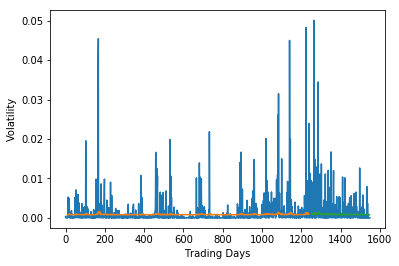

In [12]:
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(return_series)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(return_series)
testPredictPlot[:, :]= np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 2:len(return_series)-2, :] = testPredict

# Plot baseline and predictions
plt.plot(scaler.inverse_transform(return_series))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

plt.xlabel('Trading Days')
plt.ylabel('Volatility')
plt.savefig('Plot_LB-'+ str(look_back) + '_EP-'+str(epochs)+'.png', dpi=500)
plt.show()